# Import libraries, load and transform data

In [6]:
import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
from PIL import ImageFile
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel, AutoConfig, TrainingArguments, Trainer

In [8]:
# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

def adience_age_group(age):
    if age <= 2:
        return '0-2 ans'
    elif age <= 6:
        return '4-6 ans'
    elif age <= 13:
        return '8-13 ans'
    elif age <= 20:
        return '15-20 ans'
    elif age <= 32:
        return '25-32 ans'
    elif age <= 43:
        return '38-43 ans'
    elif age <= 53:
        return '48-53 ans'
    else:
        return '60 ans et plus'

# Iterate through all image files in the specified directory
images_dir = './dataset/archive/utkcropped/'
for filename in os.listdir(images_dir):
    label = adience_age_group(int(filename.split('_')[0]))
    labels.append(label)  # Add the label to the list
    file_names.append(images_dir + str(filename))  # Add the file path to the list

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

In [9]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 23709
})

In [10]:
labels_list = sorted(list(set(labels)))
label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: '0-2 ans', 1: '15-20 ans', 2: '25-32 ans', 3: '38-43 ans', 4: '4-6 ans', 5: '48-53 ans', 6: '60 ans et plus', 7: '8-13 ans'} 

Mapping of Labels to IDs: {'0-2 ans': 0, '15-20 ans': 1, '25-32 ans': 2, '38-43 ans': 3, '4-6 ans': 4, '48-53 ans': 5, '60 ans et plus': 6, '8-13 ans': 7}


In [11]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Casting the dataset: 100%|██████████| 23709/23709 [00:00<00:00, 1523326.49 examples/s]


In [12]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')

image_mean, image_std = processor.image_mean, processor.image_std
size = 224

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        # RandomRotation(90),               # Apply random rotation
        # RandomAdjustSharpness(2),         # Adjust sharpness randomly
        # RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        #normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        #normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [13]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [14]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Train model

In [16]:
class CustomDinoModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomDinoModel, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-small')
        for param in self.dino.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(self.dino.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()  # Define the loss function here

    def forward(self, pixel_values, labels=None):
        outputs = self.dino(pixel_values=pixel_values)
        cls_representation = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_representation)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        # Modify to return loss if it's computed
        return (loss, logits) if loss is not None else logits

# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = CustomDinoModel(num_labels=8)


In [17]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [22]:
metric_name = "accuracy"

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    output_dir = './facial_age_image_detection',
    evaluation_strategy="epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"  # log to none
)

In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

c:\Users\tedma\OneDrive\Bureau\PredStat\predstat-env\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
# Start training the model using the trainer object.
trainer.train()

                                                  
 20%|██        | 223/1115 [06:08<10:31,  1.41it/s]

{'eval_loss': 0.9462993741035461, 'eval_accuracy': 0.6304301982285956, 'eval_runtime': 146.0829, 'eval_samples_per_second': 64.922, 'eval_steps_per_second': 1.02, 'epoch': 1.0}


                                                     
 40%|████      | 446/1115 [11:08<06:38,  1.68it/s]

{'eval_loss': 0.9019901752471924, 'eval_accuracy': 0.6351750316322227, 'eval_runtime': 118.7306, 'eval_samples_per_second': 79.878, 'eval_steps_per_second': 1.255, 'epoch': 2.0}


 45%|████▍     | 500/1115 [11:54<08:29,  1.21it/s]  

{'loss': 1.0192, 'grad_norm': 5.010499477386475, 'learning_rate': 0.0011549295774647887, 'epoch': 2.24}


                                                  
 60%|██████    | 669/1115 [16:09<04:24,  1.68it/s]

{'eval_loss': 0.9038512110710144, 'eval_accuracy': 0.6402361872627583, 'eval_runtime': 118.8976, 'eval_samples_per_second': 79.766, 'eval_steps_per_second': 1.253, 'epoch': 3.0}


                                                    
 80%|████████  | 892/1115 [21:09<02:12,  1.68it/s]

{'eval_loss': 0.8799540400505066, 'eval_accuracy': 0.6544706874736398, 'eval_runtime': 119.2797, 'eval_samples_per_second': 79.511, 'eval_steps_per_second': 1.249, 'epoch': 4.0}


 90%|████████▉ | 1000/1115 [22:39<01:33,  1.23it/s] 

{'loss': 0.8584, 'grad_norm': 4.249307155609131, 'learning_rate': 0.000215962441314554, 'epoch': 4.48}


                                                   
100%|██████████| 1115/1115 [26:10<00:00,  1.68it/s]Checkpoint destination directory ./facial_age_image_detection\checkpoint-1115 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8661560416221619, 'eval_accuracy': 0.6530999578237031, 'eval_runtime': 118.7145, 'eval_samples_per_second': 79.889, 'eval_steps_per_second': 1.255, 'epoch': 5.0}


100%|██████████| 1115/1115 [26:11<00:00,  1.41s/it]

{'train_runtime': 1571.6714, 'train_samples_per_second': 45.254, 'train_steps_per_second': 0.709, 'train_loss': 0.927036808852123, 'epoch': 5.0}


TrainOutput(global_step=1115, training_loss=0.927036808852123, metrics={'train_runtime': 1571.6714, 'train_samples_per_second': 45.254, 'train_steps_per_second': 0.709, 'train_loss': 0.927036808852123, 'epoch': 5.0})

In [25]:
trainer.evaluate()

100%|██████████| 149/149 [01:57<00:00,  1.27it/s]


{'eval_loss': 0.8661560416221619,
 'eval_accuracy': 0.6530999578237031,
 'eval_runtime': 118.4669,
 'eval_samples_per_second': 80.056,
 'eval_steps_per_second': 1.258,
 'epoch': 5.0}

In [26]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)
# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

100%|██████████| 149/149 [01:58<00:00,  1.26it/s]

{'test_loss': 0.8661560416221619, 'test_accuracy': 0.6530999578237031, 'test_runtime': 119.5309, 'test_samples_per_second': 79.344, 'test_steps_per_second': 1.247}


Accuracy: 0.6531
F1 Score: 0.5797


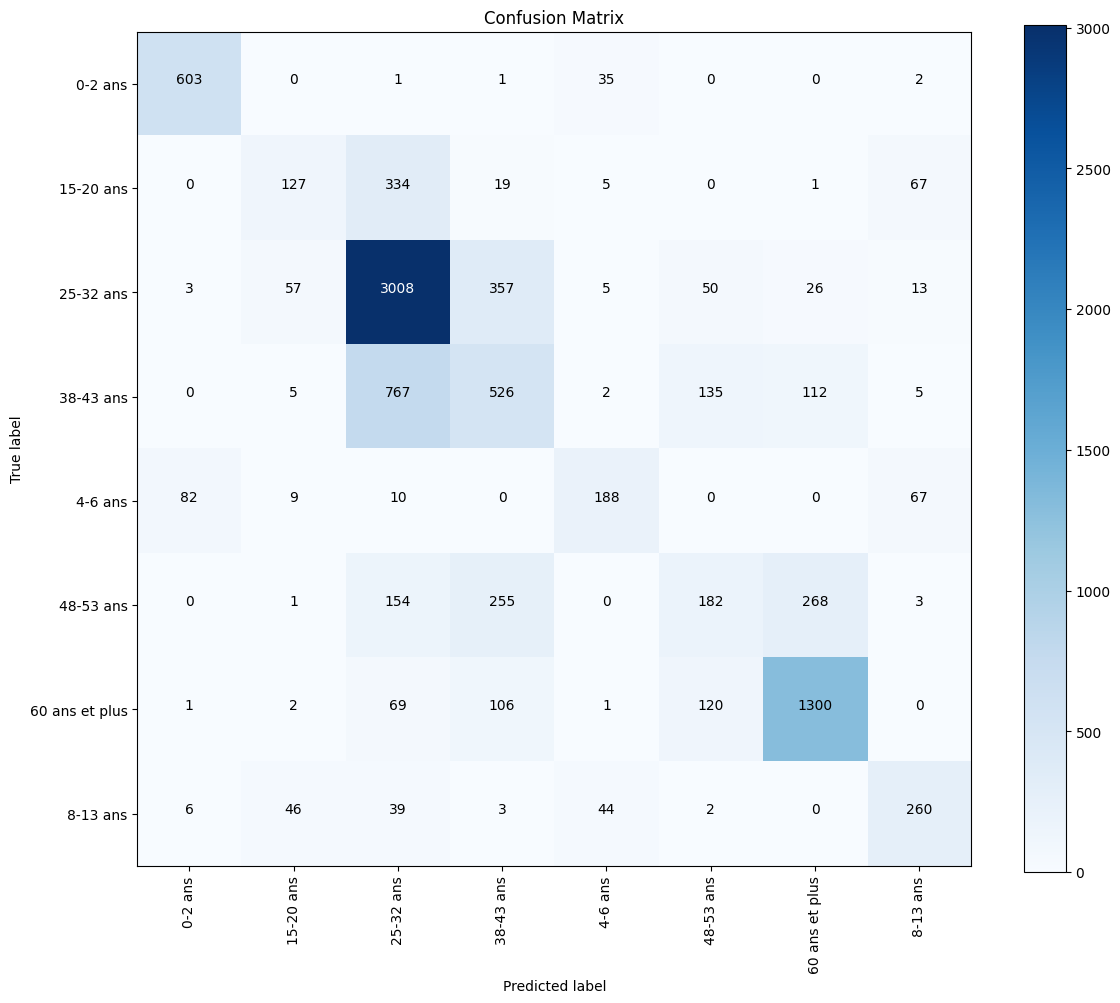


Classification report:

                precision    recall  f1-score   support

       0-2 ans     0.8676    0.9393    0.9020       642
     15-20 ans     0.5142    0.2297    0.3175       553
     25-32 ans     0.6864    0.8548    0.7614      3519
     38-43 ans     0.4152    0.3389    0.3732      1552
       4-6 ans     0.6714    0.5281    0.5912       356
     48-53 ans     0.3722    0.2109    0.2692       863
60 ans et plus     0.7616    0.8130    0.7864      1599
      8-13 ans     0.6235    0.6500    0.6365       400

      accuracy                         0.6531      9484
     macro avg     0.6140    0.5706    0.5797      9484
  weighted avg     0.6251    0.6531    0.6293      9484



In [27]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))